In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import mode, skew, kurtosis
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adamax
from sklearn import preprocessing
from keras.optimizers import SGD
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

### Main data

In [38]:
data = pd.read_csv('https://raw.githubusercontent.com/Fairtexas5/Rainfall/main/Whole_data/old_dataset.csv')
data2 = pd.read_csv('https://raw.githubusercontent.com/Fairtexas5/Rainfall/main/Whole_data/New_data_2010.csv')
data3 = pd.read_csv('https://raw.githubusercontent.com/Fairtexas5/Rainfall/main/Whole_data/New_data_2016.csv')

### BP1 Monthly data

### Creating Datasets Using Function


In [41]:
BP_data = [5, 6, 7, 8, 9] 
def Maker_dataset(dataset, name):
    for i, BP in enumerate(name): 
        num_cols = BP_data[i]
        for j in range(num_cols+1):
            BP[f't-{num_cols - j}'] = (dataset[j:140 - num_cols + j] * 10).reset_index(drop=True)
        
        BP.reset_index(drop=True, inplace=True)

In [42]:
dataset = data2

jun_column = dataset['JUN']
jul_column = dataset['JUL']
aug_column = dataset['AUG']
sep_column = dataset['SEP']
seasonal_column = dataset['JJAS']


JUN_BP1 = pd.DataFrame()
JUN_BP2 = pd.DataFrame()
JUN_BP3 = pd.DataFrame()
JUN_BP4 = pd.DataFrame()
JUN_BP5 = pd.DataFrame()

JUL_BP1 = pd.DataFrame()
JUL_BP2 = pd.DataFrame()
JUL_BP3 = pd.DataFrame()
JUL_BP4 = pd.DataFrame()
JUL_BP5 = pd.DataFrame()

AUG_BP1 = pd.DataFrame()
AUG_BP2 = pd.DataFrame()
AUG_BP3 = pd.DataFrame()
AUG_BP4 = pd.DataFrame()
AUG_BP5 = pd.DataFrame()

SEP_BP1 = pd.DataFrame()
SEP_BP2 = pd.DataFrame()
SEP_BP3 = pd.DataFrame()
SEP_BP4 = pd.DataFrame()
SEP_BP5 = pd.DataFrame()

SEAS_BP1 = pd.DataFrame()
SEAS_BP2 = pd.DataFrame()
SEAS_BP3 = pd.DataFrame()
SEAS_BP4 = pd.DataFrame()
SEAS_BP5 = pd.DataFrame()

June_Data_all = [JUN_BP1, JUN_BP2, JUN_BP3, JUN_BP4, JUN_BP5]
July_Data_all = [JUL_BP1, JUL_BP2, JUL_BP3, JUL_BP4, JUL_BP5]
Aug_Data_all = [AUG_BP1, AUG_BP2, AUG_BP3, AUG_BP4, AUG_BP5]
Sept_Data_all = [SEP_BP1, SEP_BP2, SEP_BP3, SEP_BP4, SEP_BP5]
Seasonal_Data_all = [SEAS_BP1, SEAS_BP2, SEAS_BP3, SEAS_BP4, SEAS_BP5]

# Generate data for each month
Maker_dataset(jun_column, June_Data_all)
Maker_dataset(jul_column, July_Data_all)
Maker_dataset(aug_column, Aug_Data_all)
Maker_dataset(sep_column, Sept_Data_all)
Maker_dataset(seasonal_column, Seasonal_Data_all)

for i in range(5):
    print(f"BP{i+1}:\n", June_Data_all[i].tail())

BP1:
         t-5     t-4     t-3     t-2     t-1     t-0
130  2203.0  1703.0  1617.0  1600.0  1422.0  1547.0
131  1703.0  1617.0  1600.0  1422.0  1547.0  1949.0
132  1617.0  1600.0  1422.0  1547.0  1949.0  2035.0
133  1600.0  1422.0  1547.0  1949.0  2035.0   899.0
134  1422.0  1547.0  1949.0  2035.0   899.0  1383.0
BP2:
         t-6     t-5     t-4     t-3     t-2     t-1     t-0
129  1880.0  2203.0  1703.0  1617.0  1600.0  1422.0  1547.0
130  2203.0  1703.0  1617.0  1600.0  1422.0  1547.0  1949.0
131  1703.0  1617.0  1600.0  1422.0  1547.0  1949.0  2035.0
132  1617.0  1600.0  1422.0  1547.0  1949.0  2035.0   899.0
133  1600.0  1422.0  1547.0  1949.0  2035.0   899.0  1383.0
BP3:
         t-7     t-6     t-5     t-4     t-3     t-2     t-1     t-0
128  1677.0  1880.0  2203.0  1703.0  1617.0  1600.0  1422.0  1547.0
129  1880.0  2203.0  1703.0  1617.0  1600.0  1422.0  1547.0  1949.0
130  2203.0  1703.0  1617.0  1600.0  1422.0  1547.0  1949.0  2035.0
131  1703.0  1617.0  1600.0  1422.0  1

## -------------------------------------------------------------------------------------------------

# Modelling

## Ensembling


### Customised Initializer
Customised Initializer is discussed in the paper:

<p><i>Initial weights</i>: At the beginning, neural network is assigned with small random values, because choosing initial weights too large will make the neural network untrained. In this study, we have chosen the weight (<i>w<sub>mn</sub></i>) by using the following range expression (Sivanandam and Deepa 2007):</p>

<p>&#091; <sup>-3</sup>&frasl;<sub>&radic;<span>p<sub>m</sub></sub> , <sup>3</sup>&frasl;<sub>&radic;<span >p<sub>m</sub></sub> &#093;</p>

<p>where <i>p<sub>m</sub></i> is the number of elements in <i>n</i> time series data sets that neural network to processing element <i>m</i>.</p>


In [47]:
class Sivanandam(Initializer):
    def __init__(self, pm):
        self.pm = pm

    def __call__(self, shape, dtype=None):
        limit = 3 / np.sqrt(self.pm)
        return np.random.uniform(-limit, limit, size=shape)

In [49]:
def mapping_graph(y, y_pred, year_start, BP):
    years = np.arange(year_start, year_start + len(y_pred))
    
    trace_pred = go.Scatter(x=years, y=y_pred, mode='lines+markers', name='Predicted', line=dict(color='blue'))
    trace_actual = go.Scatter(x=years, y=y, mode='lines+markers', name='Actual', line=dict(color='green'))
    
    layout = go.Layout(title=f'Model Performance of {BP}', xaxis=dict(title='YEARS'), yaxis=dict(title='Rainfall'))
    fig = go.Figure(data=[trace_pred, trace_actual], layout=layout)

    pio.show(fig)

In [52]:
def calculate_metrics(y, y_pred):
    # RMSE Calculation
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # R^2 Calculation
    r2 = r2_score(y, y_pred)

    # Mean of predicted values
    mean_pred = np.mean(y_pred)

    # Standard deviation (SD) of predicted values
    std_dev_pred = np.std(y_pred)

    # Percentage of Prediction (PP)
    pp = (np.sum((y_pred - y) ** 2) / np.sum(y ** 2)) * 100

    O_mean = y.mean()
    P_mean = y_pred.mean()

    # Store results in a dictionary
    metrics = {
        'Original Mean' : O_mean,
        'Predicted Mean' : P_mean,
        'RMSE': rmse,
        'R^2': r2,
        'Mean Predicted': mean_pred,
        'Standard Deviation Predicted': std_dev_pred,
        'Percentage of Prediction (PP)': pp
    }

    return metrics

In [54]:
# def train_bp_model(layers, data, min_val, max_val):
#     X = data.iloc[:, 0:layers + 1].values

#     # Feature Scaling (Normalization)
#     X = normalize_data(X, min_val[:layers + 1].values, max_val[:layers + 1].values)

#     # Splitting the data into features and target variable
#     y = X[:, layers]
#     X = X[:, 0:layers]

#     # Number of elements (pm) in the input time series data
#     pm = X.shape[1]

#     # Define the Neural Network
#     model = Sequential([
#         Input(shape=(layers,)),
#         Dense(units=layers + 1, kernel_initializer=Sivanandam(pm), activation='sigmoid'),  # Hidden layer
#         Dense(units=1, kernel_initializer=Sivanandam(pm), activation='sigmoid')  # Output layer
#     ])

#     # Optimizer
#     optimizer = SGD(learning_rate=0.1, momentum=0.99, nesterov=True)

#     # Compile the model
#     model.compile(optimizer=optimizer, loss='mean_squared_error')

#     # Early stopping callback to avoid overfitting
#     early_stopping = EarlyStopping(monitor='loss', min_delta=0.0001, patience=100, restore_best_weights=True)

#     # Training with early stopping
#     model.fit(X, y, batch_size=16, epochs=10000, verbose=0, callbacks=[early_stopping])

#     # Predicting the results
#     y_pred = model.predict(X)
#     y_pred = np.reshape(y_pred, y.shape)

#     return y, y_pred


In [55]:
def normalize_data(X, min_val, max_val):
    return (X - min_val) / (max_val - min_val)


def denorm_values(y, pred, max_val, min_val):
    predictions = pred * (max_val['t-0'] - min_val['t-0']) + min_val['t-0']
    true_val = y * (max_val['t-0'] - min_val['t-0']) + min_val['t-0']
    return true_val, predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


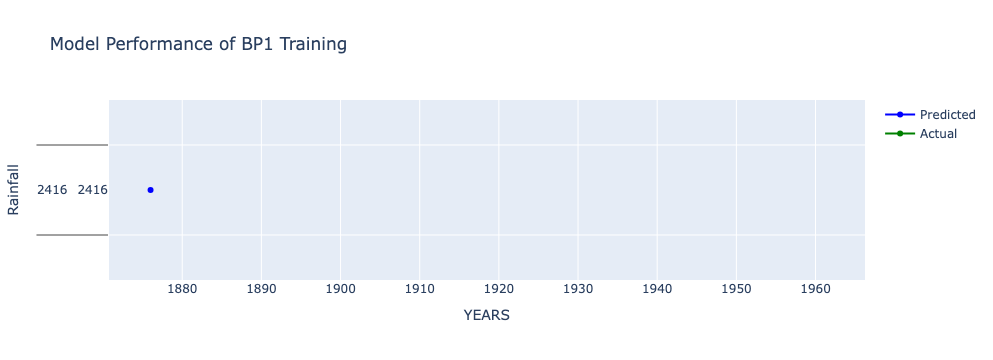

BP1 Training
Original Mean: 2637401.3720930233
Predicted Mean: 2416.0
RMSE: 2700904.501673351
R^2: -19.73958851952953
Mean Predicted: 2416.0
Standard Deviation Predicted: 0.0
Percentage of Prediction (PP): 8585.009141876237


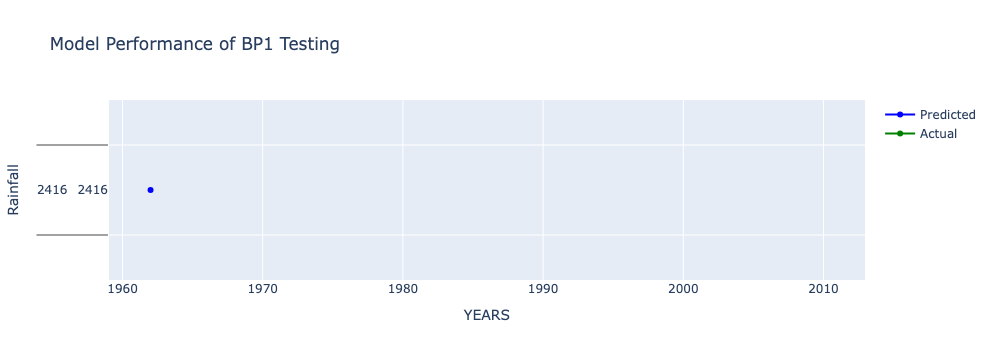

BP1 Testing
Original Mean: 2537125.7346938774
Predicted Mean: 2416.0
RMSE: 2585026.770177103
R^2: -24.939848423742177
Mean Predicted: 2416.0
Standard Deviation Predicted: 0.0
Percentage of Prediction (PP): 4891.031239366461


KeyboardInterrupt: 

In [58]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Function to normalize data
def normalize_data(X, min_val, max_val):
    return (X - min_val) / (max_val - min_val)

# Function to denormalize predictions
def denorm_values(y, pred, max_val, min_val, column='t-0'):
    predictions = pred * (max_val[column] - min_val[column]) + min_val[column]
    true_val = y * (max_val[column] - min_val[column]) + min_val[column]
    return true_val, predictions

# Function to create a custom train-test split based on a condition
def train_test_split_custom(dataset, split_condition):
    split_index = dataset[dataset.iloc[:, -1] == split_condition].index[0] + 2
    train_data = dataset.iloc[:split_index, :]
    test_data = dataset.iloc[split_index:, :]
    return train_data, test_data

def train_bp_model(layers, X_train, y_train):
    pm = X_train.shape[1]

    model = Sequential([
        Input(shape=(layers,)),
        Dense(units=layers + 1, kernel_initializer='glorot_uniform', activation='sigmoid'),  # Hidden layer
        Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid')  # Output layer
    ])

    optimizer = SGD(learning_rate=0.1, momentum=0.99, nesterov=True)
    early_stopping = EarlyStopping(monitor='loss', min_delta=0.0001, patience=100, restore_best_weights=True)

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=16, epochs=10000, verbose=0, callbacks=[early_stopping])

    return model


np.random.seed(8)
tf.random.set_seed(8)
random.seed(8)

df_results = pd.DataFrame()

for i in range(5):
    layers = 5 + i
    data = June_Data_all[i]
    year_start = 1876 + i
    min_val = data.min()
    max_val = data.max()

    train_data, test_data = train_test_split_custom(data, 1461)

    X_train = train_data.iloc[:, 0:layers].values
    y_train = train_data.iloc[:, layers].values

    X_train = normalize_data(X_train, min_val[:layers].values, max_val[:layers].values)

    X_test = test_data.iloc[:, 0:layers].values
    y_test = test_data.iloc[:, layers].values 
    
    X_test = normalize_data(X_test, min_val[:layers].values, max_val[:layers].values)
    model = train_bp_model(layers, X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # # Denormalize training predictions
    y_train_true, y_train_pred_denorm = denorm_values(y_train, y_train_pred, max_val, min_val, column='t-0')
    # # Denormalize testing predictions
    y_test_true, y_test_pred_denorm = denorm_values(y_test, y_test_pred, max_val, min_val, column='t-0')

    mapping_graph(y_train_true, y_train_pred_denorm, year_start, f'BP{i+1} Training')
    metrics = calculate_metrics(y_train_true, y_train_pred_denorm)
    print(f'BP{i+1} Training')
    for key, value in metrics.items():
        print(f'{key}: {value}')
    
    mapping_graph(y_test_true, y_test_pred_denorm, year_start + len(y_train), f'BP{i+1} Testing')
    metrics = calculate_metrics(y_test_true, y_test_pred_denorm)
    print(f'BP{i+1} Testing')
    for key, value in metrics.items():
        print(f'{key}: {value}')

    


### Work In progress

Ignore the below for now...

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


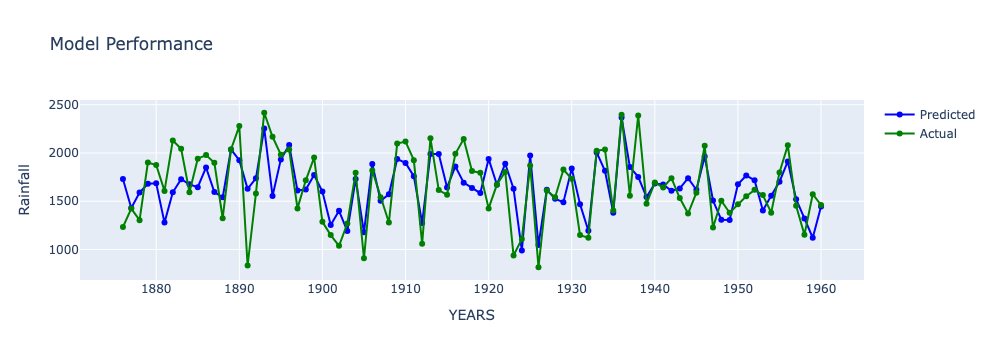

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


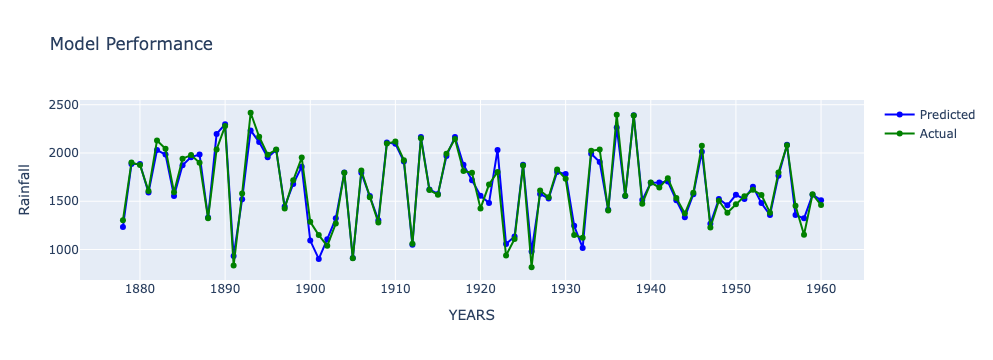

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


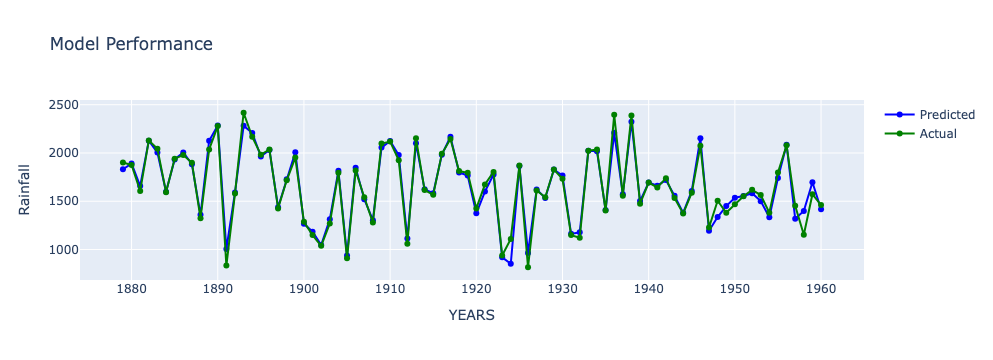

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


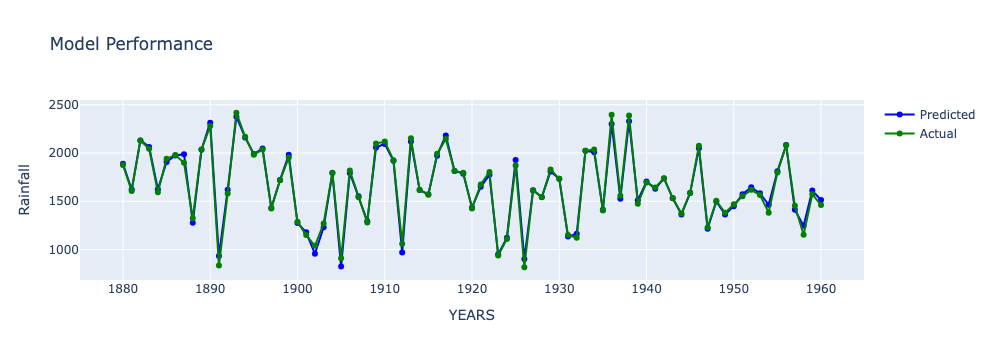

    Year  Actual          bp1          bp2          bp3          bp4  \
0   1876  1233.0  1729.566895     0.000000     0.000000     0.000000   
1   1877  1424.0  1430.074341  1533.869629     0.000000     0.000000   
2   1878  1304.0  1590.620972  1345.394287  1234.295044     0.000000   
3   1879  1901.0  1681.015625  1921.619019  1885.326294  1831.849854   
4   1880  1876.0  1685.717407  1908.480347  1887.071289  1889.908813   
..   ...     ...          ...          ...          ...          ...   
80  1956  2079.0  1912.568726  2148.806641  2084.464111  2086.368652   
81  1957  1453.0  1520.603760  1249.645264  1357.060547  1319.284668   
82  1958  1152.0  1321.888184  1470.681152  1322.538086  1399.117676   
83  1959  1573.0  1121.648315  1473.187988  1567.446289  1697.067383   
84  1960  1461.0  1446.508057  1569.094238  1510.755127  1417.145752   

            bp5     ensemble  
0      0.000000  1729.566895  
1      0.000000  1481.971985  
2      0.000000  1390.103434  
3      0.00

In [48]:
np.random.seed(8)
tf.random.set_seed(8)
random.seed(8)

for i in range(5):
    layers = 5+i 
    data = June_Data_all[i]
    year_start = 1876 + i
    min_val = data.min()
    max_val = data.max()
    y, y_pred = train_bp_model(layers, data, min_val, max_val)
    year_start = 1876 + i
    column = 'bp' + str(i+1)

    y_true, y_pred_denorm = denorm_values(y, y_pred, max_val, min_val)
    df_results = insert_pred_data(df_results, y_pred_denorm, year_start, column)
    mapping_graph(y_true, y_pred_denorm, year_start)


print(df_results)

In [54]:
# Function to calculate the average, ignoring zeros
def calculate_ensemble(row):
    non_zero_values = [val for val in row if val != 0]  # Get only non-zero values
    if len(non_zero_values) > 0:
        return sum(non_zero_values) / len(non_zero_values)  # Average of non-zero values
    else:
        return 0  # If all values are zero, return 0

# Apply the ensemble calculation across each row for 'bp1', 'bp2', 'bp3', 'bp4', and 'bp5'
df_results['ensemble'] = df_results[['bp1', 'bp2', 'bp3', 'bp4', 'bp5']].apply(calculate_ensemble, axis=1)

# Display the updated DataFrame
print(df_results.head())

   Year  Actual          bp1          bp2          bp3          bp4  \
0  1876  1233.0  1729.566895     0.000000     0.000000     0.000000   
1  1877  1424.0  1430.074341  1533.869629     0.000000     0.000000   
2  1878  1304.0  1590.620972  1345.394287  1234.295044     0.000000   
3  1879  1901.0  1681.015625  1921.619019  1885.326294  1831.849854   
4  1880  1876.0  1685.717407  1908.480347  1887.071289  1889.908813   

           bp5     ensemble  
0     0.000000  1729.566895  
1     0.000000  1481.971985  
2     0.000000  1390.103434  
3     0.000000  1829.952698  
4  1888.678833  1851.971338  


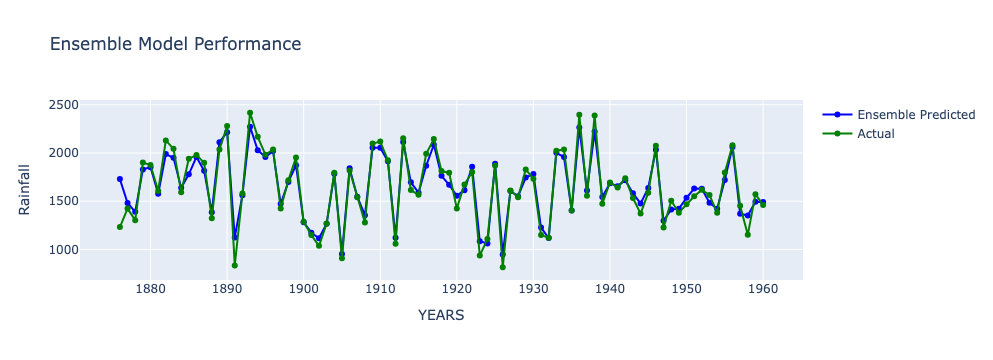

RMSE: 97.00158829119967
R^2: 0.9319590713451966
Mean Predicted: 1648.749517654718
Standard Deviation Predicted: 316.20087795645827
Percentage of Prediction (PP): 0.34348624570724295


In [56]:
def mapping_ensemble_graph(y_actual, y_ensemble, year_start):
    years = np.arange(year_start, year_start + len(y_ensemble))
    
    trace_ensemble = go.Scatter(x=years, y=y_ensemble, mode='lines+markers', name='Ensemble Predicted', line=dict(color='blue'))
    trace_actual = go.Scatter(x=years, y=y_actual, mode='lines+markers', name='Actual', line=dict(color='green'))
    
    layout = go.Layout(title='Ensemble Model Performance', xaxis=dict(title='YEARS'), yaxis=dict(title='Rainfall'))
    fig = go.Figure(data=[trace_ensemble, trace_actual], layout=layout)

    pio.show(fig)


# Assuming 'y' contains actual values and 'ensemble' contains the ensemble predictions:
mapping_ensemble_graph(df_results['Actual'], df_results['ensemble'], 1876)

metrics = calculate_metrics(df_results['Actual'], df_results['ensemble'])
for key, value in metrics.items():
    print(f'{key}: {value}')

In [ ]:
# from sklearn.model_selection import ParameterGrid

# batch_sizes = [8, 16, 32, 64, 128]

# def grid_search_batch_size(layers, data):
#     best_rmse = float('inf')
#     best_batch_size = None

#     for batch_size in batch_sizes:
#         print(f"Training with batch size: {batch_size}")
#         y, y_pred = train_bp_model(layers, data, batch_size=batch_size)
        
#         # RMSE Calculation
#         rmse = np.sqrt(mean_squared_error(y, y_pred))
#         print(f"Batch size: {batch_size}, RMSE: {rmse}")

#         # Keep track of the best batch size
#         if rmse < best_rmse:
#             best_rmse = rmse
#             best_batch_size = batch_size

#     print(f"Best batch size: {best_batch_size} with RMSE: {best_rmse}")
#     return best_batch_size

# layers = 9  # Example for BP1
# data = June_Data_all[4]  # Example for BP1 data
# best_batch_size = grid_search_batch_size(layers, data)

# # # Use the best batch size to train all models
# # for i in range(5):
# #     layers = 5 + i  # Increment layers
# #     data = June_Data_all[i]  # Select corresponding data
# #     y, y_pred = train_bp_model(layers, data, batch_size=best_batch_size)  # Use the best batch size


BP1 :-  8 <br>
BP2 :-  16 <br>
BP3 :-  16 <br>
BP4 :-  16  <br>
BP5 :-  16

In [ ]:
# del data, data2, data3, dataset, JUN_BP1, JUN_BP2, JUN_BP3, JUN_BP4, JUN_BP5, JUL_BP1, JUL_BP2, JUL_BP3, JUL_BP4, JUL_BP5, AUG_BP1, AUG_BP2, AUG_BP3, AUG_BP4, AUG_BP5, SEP_BP1, SEP_BP2, SEP_BP3, SEP_BP4, SEP_BP5, SEAS_BP1, SEAS_BP2, SEAS_BP3, SEAS_BP4, SEAS_BP5